In [1]:
import networkx as nx
import os
import matplotlib.pyplot as plt
from networkx.algorithms.dominating import is_dominating_set
from networkx.algorithms.bipartite import is_bipartite
from networkx.algorithms.bipartite.matching import *
from networkx.algorithms.bipartite.covering import *

In [2]:
folder_path = "./rep_data_set/"
filename= "graph_50_50"

In [3]:
def load_graph(name):
    with open(name, "r") as f:
        state = 0
        G = None
        for l in f:
            if state == 0:  # Header nb of nodes
                state = 1
            elif state == 1:  # Nb of nodes
                nodes = int(l)
                state = 2
            elif state == 2:  # Header position
                i = 0
                state = 3
            elif state == 3:  # Position
                i += 1
                if i >= nodes:
                    state = 4
            elif state == 4:  # Header node weight
                i = 0
                state = 5
                G = nx.Graph()
            elif state == 5:  # Node weight
                G.add_node(i, weight=int(l))
                i += 1
                if i >= nodes:
                    state = 6
            elif state == 6:  # Header edge
                i = 0
                state = 7
            elif state == 7:
                if i > nodes:
                    pass
                else:
                    edges = l.strip().split(" ")
                    for j, w in enumerate(edges):
                        w = int(w)
                        if w == 1 and (not i == j):
                            G.add_edge(i, j)
                    i += 1

        return G

In [4]:
g = nx.read_adjlist(os.path.join(folder_path, filename))

In [5]:
graph_loaded = load_graph(folder_path+filename)

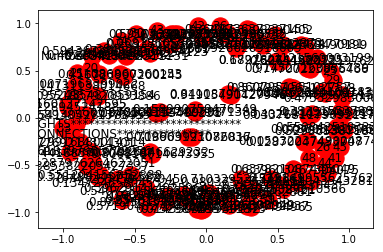

In [6]:
nx.draw_networkx(g)

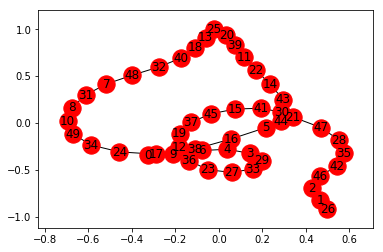

In [7]:
nx.draw_networkx(graph_loaded)

In [8]:
def order_cycle_graph(g) :
    """
    sort the graph according to the succession of nodes
    """
    first_node = list(g.nodes)[0] #take 1st node
    result = [first_node] # result list
    result.append(list(g[first_node])[0]) # add 1st neigbour
    while len(result) != g.order() : # while we don't have all nodes sorted
        neighbours = list(g[result[-1]]) #get last nodes neighbours
        neighbours.remove(result[-2]) # remove sorted neighbour
        result.append(neighbours[0]) # add last neighbour
    return result

def cycle_dominant(g):
    dominant_set = set()
    ordered_graph = order_cycle_graph(g)
    for i in range(0, len(ordered_graph), 3):
        dominant_set.add(ordered_graph[i])
    return dominant_set

#### Dominant ####

def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """

    all_nodes = set(g)
    neighbours_nb = {} # Dict where the key is the number of neighbours and the item is the node
    for node in all_nodes :
        neighbours_nb[g.degree[node]] = node

    if len(neighbours_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) : # Cycle graph case
        return cycle_dominant(g)

    else : # greedy algorithm

        max_neighbours = max(neighbours_nb.keys()) #node with the most neighbours
        max_node = neighbours_nb[max_neighbours]        
        dominating_set = {max_node}

        not_selected = all_nodes - {max_node} #nodes not selected for dominant
        all_nodes = all_nodes - set(g[max_node]) - {max_node} #nodes not "dominated"
        g = g.subgraph(not_selected) # graph remaining (without dominant nodes)

        while all_nodes :

            neighbours_nb = {} # same dict as before but this time we don't count nodes "dominated"
            for node in not_selected :
                remaining_reighbours = []
                for node2 in list(g[node]) :
                    if node2 in all_nodes :
                        remaining_reighbours.append(node2)
                neighbours_nb[len(remaining_reighbours)] = node


            if len(neighbours_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) : # Cycle graph case
                dominating_set |= cycle_dominant(g)
                return dominating_set

            max_neighbours = max(neighbours_nb.keys())
            max_node = neighbours_nb[max_neighbours]
            dominating_set.add(max_node)

            not_selected = not_selected - {max_node}
            all_nodes = all_nodes - set(g[max_node]) - {max_node}
            g = g.subgraph(not_selected)

    return dominating_set

In [22]:
for filename in os.listdir(folder_path):
        graph_loaded = load_graph(os.path.join(folder_path, filename))
        print(dominant(graph_loaded))

{38, 9, 43, 44, 45, 14, 23}
{1, 11, 15, 20, 43, 48, 56, 58, 69, 76, 85, 99, 101, 105, 107, 113, 115, 117, 128, 134, 138, 139, 140, 142, 145, 148, 151, 158, 159, 162, 164, 187, 193, 195, 197, 206, 219, 221, 222, 223, 224, 226, 232, 233, 235, 236, 240, 246, 252, 253, 258, 267, 269, 272, 274, 275, 276, 277, 282, 283, 288, 289, 292, 293, 294, 300, 301, 302, 313, 314, 315, 318, 320, 321, 323, 325, 331, 332, 333, 337, 338, 339, 348, 350, 351, 355, 357, 359, 360, 362, 367, 368, 370, 371, 372, 373, 374, 375, 376, 378, 384, 389, 390, 395, 396, 398, 399, 402, 403, 404, 408, 410, 418, 421, 426, 427, 428, 429, 431, 433, 434, 435, 436, 437, 438, 440, 444, 446, 456, 458, 459, 464, 465, 471, 472, 474, 478, 484, 488, 490, 491, 492, 493, 494, 496, 497, 499}
{6, 9, 14, 18, 20, 21, 26, 29, 30, 31, 33, 34, 36, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49}
{96, 33, 98, 67, 99, 7, 87, 93, 95}
{132, 133, 5, 137, 138, 13, 15, 150, 23, 158, 31, 159, 160, 34, 165, 38, 167, 40, 169, 174, 47, 50, 180, 182, 183, 57, 61,

In [20]:
print(graph_loaded.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


AttributeError: 'set' object has no attribute 'edges'

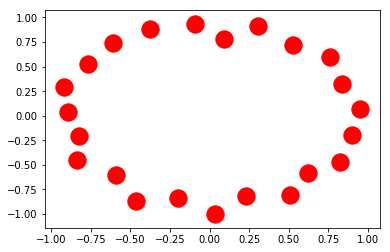

In [12]:
nx.draw_networkx(dominant(graph_loaded))